# Build CNN on MNIST data with following features:
- data augmentation
- advance CNN architecture
- optimized on least model parameters with maximum accuracy

In [1]:
# Import Libraries

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
import warnings

# Ignore specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

---
---

## Notebook Summary:
1. **Target:** 
    - Increase model capacity but continue having total parameters under 8k
    - Include data augmentation like rotation, cutout and others
    - fine tune learning rate and other parameter
2. **Results:** 
    - Parameters: 5,672
    - Best Training Accuracy: 99.99
    - Best Test Accuracy: 99.24
3. **Analysis:** 
    - Total parameters reduced from 9k to 6k
    - We can see batch norm and dropout is working
    - model is under-performing
    - Model performance is up but there is scope of further training
    - As

---
---
## Hyperparameters

In [36]:
# Hyperparameters class for easy tuning
class HyperParameters:
    def __init__(self):
        self.num_epochs = 15
        self.batch_size = 64
        self.learning_rate = 0.001
        self.dropout_rate = 0.1
        self.num_classes = 10
        self.momentum = 0.95
        self.random_seed = 193

# Initialize hyperparameters
params = HyperParameters()
print(params.__dict__)

{'num_epochs': 15, 'batch_size': 64, 'learning_rate': 0.001, 'dropout_rate': 0.1, 'num_classes': 10, 'momentum': 0.95, 'random_seed': 193}


## Data Transformations & Tain/Test data loader

In [37]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random shifts
                                       transforms.RandomPerspective(distortion_scale=0.2, p=0.5), # Perspective changes
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [38]:
# Load MNIST dataset
train = datasets.MNIST('./../data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./../data', train=False, download=True, transform=test_transforms)

In [39]:
# Create data loaders

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(params.random_seed)

if cuda:
    torch.cuda.manual_seed(params.random_seed)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=params.batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=params.batch_size)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## CNN Model Architecture 

In [40]:
dropout_value = params.dropout_rate
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Summary

In [41]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = TinyCNN().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             128
        MaxPool2d-10           [-1, 16, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]           1,728
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
          Dropout-14           [-1

## Train & Test Functions

In [42]:
# train

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

In [43]:
# test

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Run Model

In [44]:
# load Model

model =  TinyCNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.95)

In [45]:
EPOCHS = params.num_epochs
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.03820253536105156 Batch_id=937 Accuracy=89.43: 100%|██████████| 938/938 [00:33<00:00, 27.63it/s] 


Test set: Average loss: 0.0562, Accuracy: 9818/10000 (98.18%)
EPOCH: 1


Loss=0.21755394339561462 Batch_id=937 Accuracy=96.57: 100%|██████████| 938/938 [00:31<00:00, 29.47it/s] 


Test set: Average loss: 0.0359, Accuracy: 9876/10000 (98.76%)
EPOCH: 2


Loss=0.055336423218250275 Batch_id=937 Accuracy=97.22: 100%|██████████| 938/938 [00:31<00:00, 29.42it/s] 


Test set: Average loss: 0.0371, Accuracy: 9883/10000 (98.83%)
EPOCH: 3


Loss=0.03601962700486183 Batch_id=937 Accuracy=97.43: 100%|██████████| 938/938 [00:31<00:00, 30.04it/s]  


Test set: Average loss: 0.0413, Accuracy: 9866/10000 (98.66%)
EPOCH: 4


Loss=0.020515326410531998 Batch_id=937 Accuracy=97.68: 100%|██████████| 938/938 [00:31<00:00, 29.88it/s] 


Test set: Average loss: 0.0267, Accuracy: 9916/10000 (99.16%)
EPOCH: 5


Loss=0.004114234820008278 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [00:31<00:00, 29.33it/s] 


Test set: Average loss: 0.0321, Accuracy: 9894/10000 (98.94%)
EPOCH: 6


Loss=0.019211674109101295 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [00:32<00:00, 29.28it/s] 


Test set: Average loss: 0.0352, Accuracy: 9892/10000 (98.92%)
EPOCH: 7


Loss=0.14865656197071075 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:32<00:00, 29.28it/s]  


Test set: Average loss: 0.0342, Accuracy: 9892/10000 (98.92%)
EPOCH: 8


Loss=0.03836209699511528 Batch_id=937 Accuracy=98.01: 100%|██████████| 938/938 [00:30<00:00, 30.64it/s]  


Test set: Average loss: 0.0287, Accuracy: 9912/10000 (99.12%)
EPOCH: 9


Loss=0.061582569032907486 Batch_id=937 Accuracy=98.12: 100%|██████████| 938/938 [00:29<00:00, 31.36it/s] 


Test set: Average loss: 0.0309, Accuracy: 9905/10000 (99.05%)
EPOCH: 10


Loss=0.019799700006842613 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:31<00:00, 30.03it/s] 


Test set: Average loss: 0.0295, Accuracy: 9900/10000 (99.00%)
EPOCH: 11


Loss=0.008343796245753765 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [00:30<00:00, 30.38it/s] 


Test set: Average loss: 0.0376, Accuracy: 9888/10000 (98.88%)
EPOCH: 12


Loss=0.04581413045525551 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [00:32<00:00, 28.61it/s]  


Test set: Average loss: 0.0255, Accuracy: 9920/10000 (99.20%)
EPOCH: 13


Loss=0.15035536885261536 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [00:31<00:00, 29.60it/s]  


Test set: Average loss: 0.0236, Accuracy: 9928/10000 (99.28%)
EPOCH: 14


Loss=0.042149558663368225 Batch_id=937 Accuracy=98.24: 100%|██████████| 938/938 [00:32<00:00, 29.29it/s] 


Test set: Average loss: 0.0285, Accuracy: 9913/10000 (99.13%)


In [ ]:
# # Optimizing Learning rate
# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

# EPOCHS = params.num_epochs
# for epoch in range(EPOCHS):
#     print("EPOCH:", epoch)
#     train(model, device, train_loader, optimizer)
#     scheduler.step()
#     test(model, device, test_loader)

In [46]:
# Optimizing Learning rate
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(
   optimizer,
   mode='max',           # Since we're tracking accuracy
   factor=0.1,          # Multiply lr by this factor when plateauing
   patience=1,          # Number of epochs to wait before reducing lr
   verbose=True,        # Print message when lr is reduced
   min_lr=1e-6         # Don't reduce lr below this value
)

EPOCHS = params.num_epochs
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer)
    test(model, device, test_loader)
    scheduler.step(test_acc[-1])  # Using the latest test accuracy

EPOCH: 0


Loss=0.015713615342974663 Batch_id=937 Accuracy=98.24: 100%|██████████| 938/938 [00:32<00:00, 29.28it/s] 


Test set: Average loss: 0.0217, Accuracy: 9932/10000 (99.32%)
EPOCH: 1


Loss=0.05649750679731369 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [00:31<00:00, 29.83it/s]  


Test set: Average loss: 0.0259, Accuracy: 9912/10000 (99.12%)
EPOCH: 2


Loss=0.010371697135269642 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:32<00:00, 29.27it/s] 


Test set: Average loss: 0.0207, Accuracy: 9931/10000 (99.31%)
EPOCH: 3


Loss=0.0013806894421577454 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:31<00:00, 30.15it/s]


Test set: Average loss: 0.0188, Accuracy: 9938/10000 (99.38%)
EPOCH: 4


Loss=0.07105262577533722 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:32<00:00, 29.10it/s]  


Test set: Average loss: 0.0188, Accuracy: 9936/10000 (99.36%)
EPOCH: 5


Loss=0.03711731731891632 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:31<00:00, 29.83it/s]  


Test set: Average loss: 0.0186, Accuracy: 9938/10000 (99.38%)
EPOCH: 6


Loss=0.0078047276474535465 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:32<00:00, 28.46it/s]


Test set: Average loss: 0.0188, Accuracy: 9934/10000 (99.34%)
EPOCH: 7


Loss=0.006340018007904291 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:31<00:00, 29.62it/s] 


Test set: Average loss: 0.0187, Accuracy: 9937/10000 (99.37%)
EPOCH: 8


Loss=0.042610280215740204 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:28<00:00, 33.12it/s] 


Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99.41%)
EPOCH: 9


Loss=0.02976718172430992 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:31<00:00, 29.37it/s]  


Test set: Average loss: 0.0190, Accuracy: 9937/10000 (99.37%)
EPOCH: 10


Loss=0.13371331989765167 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:31<00:00, 30.24it/s]  


Test set: Average loss: 0.0189, Accuracy: 9937/10000 (99.37%)
EPOCH: 11


Loss=0.007168160285800695 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:32<00:00, 28.92it/s] 


Test set: Average loss: 0.0188, Accuracy: 9935/10000 (99.35%)
EPOCH: 12


Loss=0.12049590051174164 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:31<00:00, 29.76it/s]  


Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99.34%)
EPOCH: 13


Loss=0.021973032504320145 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:31<00:00, 29.78it/s] 


Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)
EPOCH: 14


Loss=0.07777255773544312 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:31<00:00, 29.34it/s]  


Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)


In [47]:
# Optimizing Learning rate
from torch.optim.lr_scheduler import OneCycleLR
scheduler = OneCycleLR(
   optimizer,
   max_lr=0.02,  # Maximum learning rate
   epochs=params.num_epochs,
   steps_per_epoch=len(train_loader),
   pct_start=0.3,  # Percentage of training to increase lr
   anneal_strategy='cos'  # Cosine annealing
)

EPOCHS = params.num_epochs
for epoch in range(EPOCHS):
   print("EPOCH:", epoch)
   train(model, device, train_loader, optimizer)
   scheduler.step()  # Step the scheduler
   test(model, device, test_loader)

EPOCH: 0


Loss=0.01079915463924408 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:32<00:00, 28.80it/s]  


Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.34%)
EPOCH: 1


Loss=0.02418317086994648 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:31<00:00, 29.54it/s]  


Test set: Average loss: 0.0181, Accuracy: 9939/10000 (99.39%)
EPOCH: 2


Loss=0.02786588855087757 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:31<00:00, 30.16it/s]  


Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)
EPOCH: 3


Loss=0.02055438421666622 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:31<00:00, 29.55it/s]  


Test set: Average loss: 0.0200, Accuracy: 9934/10000 (99.34%)
EPOCH: 4


Loss=0.10543905943632126 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:31<00:00, 29.50it/s]  


Test set: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)
EPOCH: 5


Loss=0.08273342251777649 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:32<00:00, 28.53it/s]  


Test set: Average loss: 0.0191, Accuracy: 9934/10000 (99.34%)
EPOCH: 6


Loss=0.01887224055826664 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:33<00:00, 27.65it/s]  


Test set: Average loss: 0.0190, Accuracy: 9935/10000 (99.35%)
EPOCH: 7


Loss=0.0659257099032402 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:32<00:00, 29.28it/s]   


Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)
EPOCH: 8


Loss=0.004657885991036892 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:31<00:00, 29.41it/s]  


Test set: Average loss: 0.0200, Accuracy: 9930/10000 (99.30%)
EPOCH: 9


Loss=0.0569903664290905 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:32<00:00, 29.30it/s]   


Test set: Average loss: 0.0183, Accuracy: 9939/10000 (99.39%)
EPOCH: 10


Loss=0.02132474072277546 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:31<00:00, 29.50it/s]  


Test set: Average loss: 0.0189, Accuracy: 9942/10000 (99.42%)
EPOCH: 11


Loss=0.002704822225496173 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:31<00:00, 29.71it/s] 


Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)
EPOCH: 12


Loss=0.05704093351960182 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:31<00:00, 29.37it/s]  


Test set: Average loss: 0.0189, Accuracy: 9939/10000 (99.39%)
EPOCH: 13


Loss=0.026168499141931534 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:31<00:00, 29.44it/s] 


Test set: Average loss: 0.0187, Accuracy: 9935/10000 (99.35%)
EPOCH: 14


Loss=0.0031632748432457447 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:31<00:00, 29.63it/s]


Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)


> Model accuracy is oscillating between 99.3 to 99.4

## Plots

In [48]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Calculate epoch-level training accuracy
train_acc_epoch = []
for i in range(0, len(train_acc), len(train_loader)):
   train_acc_epoch.append(train_acc[i])
# Create figure
fig = go.Figure()
# Add traces for training and test accuracy
fig.add_trace(
   go.Scatter(
       x=list(range(1, params.num_epochs + 1)),
       y=train_acc_epoch,
       mode='lines+markers',
       name='Train Accuracy',
       line=dict(color='blue')
   )
)
fig.add_trace(
   go.Scatter(
       x=list(range(1, params.num_epochs + 1)),
       y=test_acc,
       mode='lines+markers',
       name='Test Accuracy',
       line=dict(color='red')
   )
)
# Update layout
fig.update_layout(
   title='Model Accuracy per Epoch',
   xaxis_title='Epochs',
   yaxis_title='Accuracy (%)',
   hovermode='x unified',
   template='plotly_white',
   width=1000,
   height=600
)
# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.show()

Text(0.5, 1.0, 'Test Accuracy')

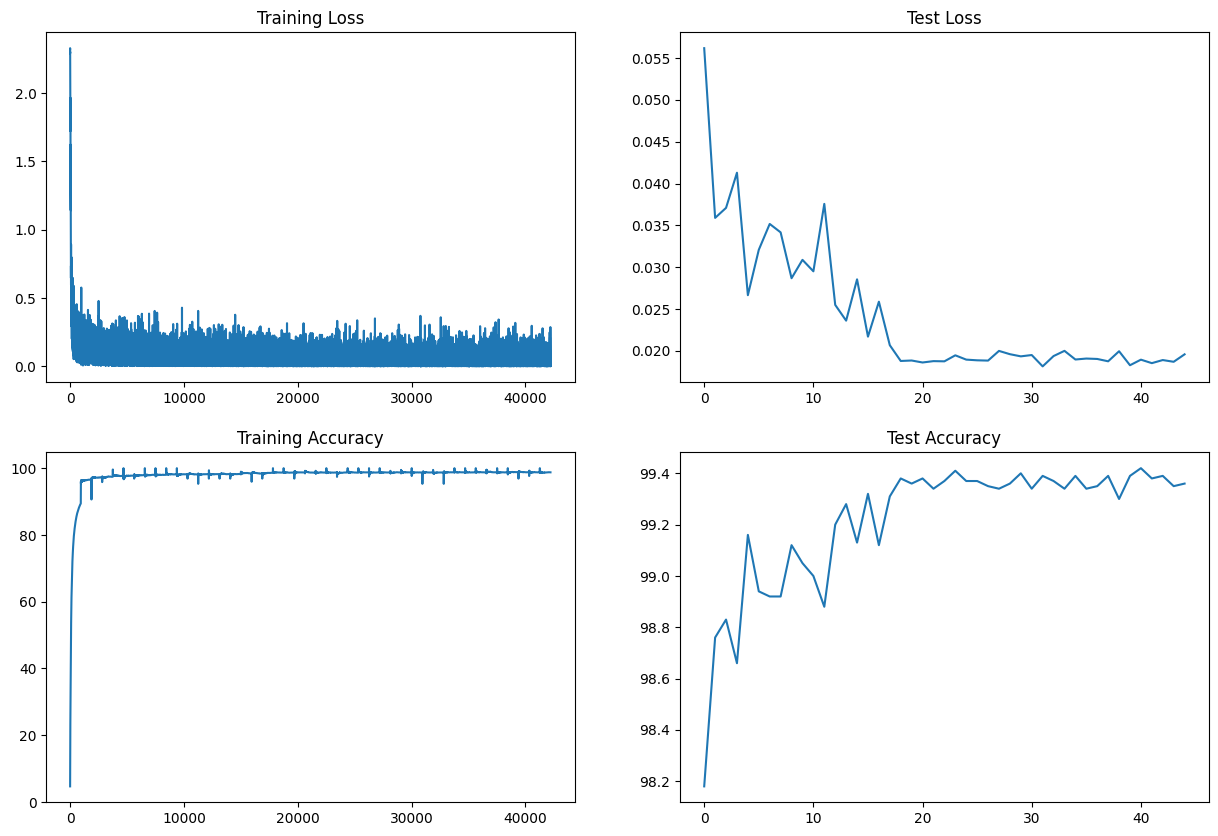

In [49]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

ValueError: x and y must have same first dimension, but have shapes (15,) and (45,)

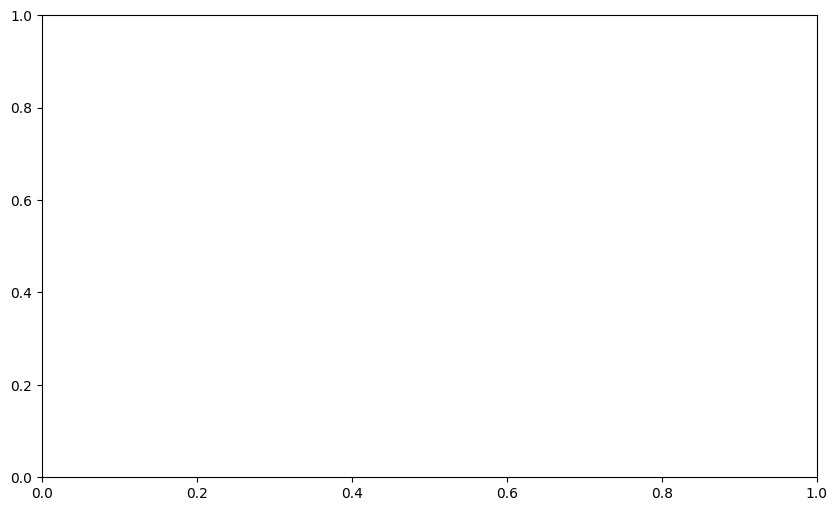

In [50]:
# Calculate epoch-level training accuracy
train_acc_epoch = []
for i in range(0, len(train_acc), len(train_loader)):  # len(train_loader) = 938
   train_acc_epoch.append(train_acc[i])
plt.figure(figsize=(10,6))
plt.plot(range(1, params.num_epochs + 1), train_acc_epoch, label='Train Accuracy', marker='o')
plt.plot(range(1, params.num_epochs + 1), test_acc, label='Test Accuracy', marker='o')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
